# Open and plot

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec

import os
import glob
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from bkgndLibs.PINEM import *
from bkgndLibs.electronFns import *
from bkgndLibs.T_modes_cylinder import *
from PINEM_tests.config.savepaths import savedir

from itertools import product

In [20]:
import h5py
h5py.__version__

'2.10.0'

In [21]:
# savedir = r'/storage/work/rjm6826/data/*.h5' # * means all if need specific format then *.csv

list_of_files = glob.glob(savedir) 
list_of_files = sorted(list_of_files, key=os.path.getctime)
list_of_files = [f for f in list_of_files if 'tcav' in f]
# savefile = max(list_of_files, key=os.path.getctime)
# savefile = max(list_of_files, key=os.path.getmtime)
savefile = list_of_files[-1]
savefile

# savefile = r'/storage/home/rjm6826/data/tcav_061224_163138.h5'

'/storage/work/rjm6826/data/110124_154114_tcav.h5'

In [22]:
with h5py.File(savefile, 'r') as hf:
    print(hf.keys())
    print(hf['Probability'][:].shape)

with h5py.File(savefile, 'r') as hf:
    prob_mats = np.zeros(hf['Probability'][:].shape, dtype='complex')
    prob_mats[:,:,:] = np.copy(hf['Probability'][:])
    loaded_metadata = {key: hf['metadata'].attrs[key] for key in hf['metadata'].attrs}
    
    if loaded_metadata['Save coupling?']:
        gQ = np.copy(hf['Coupling'][:])


<KeysViewHDF5 ['Probability', 'metadata']>
(22400, 15, 15)


In [23]:
loaded_metadata

{'Electron energy range': 20000.0,
 'Enforce phase': False,
 'Lcav': 0.0001,
 'Maximum electron energy': 209117.50942468643,
 'Maximum time delay multiplier': 1.0,
 'Minimum time delay multiplier': 0.95,
 'Not a tensor product': True,
 'Number of cavities': 2,
 'Number of electron energies': 160,
 'Number of electrons': 1,
 'Number of free space lengths': 140,
 'Number of time delays': 1,
 'Phase maximum multiplier': 1.0,
 'Phase minimum multiplier': 0.0,
 'Phase reference': 1,
 'Save coupling?': False,
 'Save rho?': False,
 'alpha1': 0.5,
 'alpha2': 0.5,
 'author': 'Rick Mueller',
 'date': '11/01/2024',
 'date_ran': '2024-11-01',
 'e_E_max_g': 199117.50942468643,
 'eps1': 3.581452955152137e-11,
 'eps2': 8.854187817e-12,
 'file_name': 't241031.h5',
 'l': 1,
 'm': 1,
 'n_states': 15,
 'name': 'Plane wave',
 'omega': 1771465844363484.2,
 'radius': 2.315e-07,
 'type': 'HE'}

In [24]:
# Create save path
plot_file_umbrella = savefile.split(".")[0]

In [25]:
Es = np.linspace(loaded_metadata['Maximum electron energy'] - loaded_metadata['Electron energy range'], 
                 loaded_metadata['Maximum electron energy'], 
                 loaded_metadata['Number of electron energies'])
Lfree = np.linspace(loaded_metadata['Phase minimum multiplier']*loaded_metadata['Phase reference'], 
                    loaded_metadata['Phase maximum multiplier']*loaded_metadata['Phase reference'], 
                    loaded_metadata['Number of free space lengths'])
# Time delay (between cavity1 and cavity 2 photons)
t_delay_ref = Lfree / EnT_to_vvec(loaded_metadata['Maximum electron energy'],0,True)[2]

t_delay = np.zeros((loaded_metadata['Number of free space lengths'], 
                     loaded_metadata['Number of time delays']))


for i, l in enumerate(Lfree):
    t_delay[i,:] = np.linspace(loaded_metadata['Minimum time delay multiplier']*t_delay_ref[i],
                            loaded_metadata['Maximum time delay multiplier']*t_delay_ref[i],
                            loaded_metadata['Number of time delays'])

In [26]:
Lfree

array([0.        , 0.00719424, 0.01438849, 0.02158273, 0.02877698,
       0.03597122, 0.04316547, 0.05035971, 0.05755396, 0.0647482 ,
       0.07194245, 0.07913669, 0.08633094, 0.09352518, 0.10071942,
       0.10791367, 0.11510791, 0.12230216, 0.1294964 , 0.13669065,
       0.14388489, 0.15107914, 0.15827338, 0.16546763, 0.17266187,
       0.17985612, 0.18705036, 0.1942446 , 0.20143885, 0.20863309,
       0.21582734, 0.22302158, 0.23021583, 0.23741007, 0.24460432,
       0.25179856, 0.25899281, 0.26618705, 0.27338129, 0.28057554,
       0.28776978, 0.29496403, 0.30215827, 0.30935252, 0.31654676,
       0.32374101, 0.33093525, 0.3381295 , 0.34532374, 0.35251799,
       0.35971223, 0.36690647, 0.37410072, 0.38129496, 0.38848921,
       0.39568345, 0.4028777 , 0.41007194, 0.41726619, 0.42446043,
       0.43165468, 0.43884892, 0.44604317, 0.45323741, 0.46043165,
       0.4676259 , 0.47482014, 0.48201439, 0.48920863, 0.49640288,
       0.50359712, 0.51079137, 0.51798561, 0.52517986, 0.53237

In [27]:
g2 = dict({})
QMI_ar = dict({})
n2 = dict({})

In [28]:
intm1 = np.array([(e, l, t) for e in Es \
                 for l, t_row in zip(Lfree, t_delay) \
                    for t in t_row])
# intm1

## Second order correlation function $g^2$

In [29]:
# plt.plot(Es, gQ[:,0,0,0])

<ipython-input-30-b2e1c7d5db4a>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  g2tempArr[i,j] = g2_FromFinalState(prob_mats[ct,:,:], n)


/storage/work/rjm6826/data/110124_154114_tcav_g2_15_FockStates.png


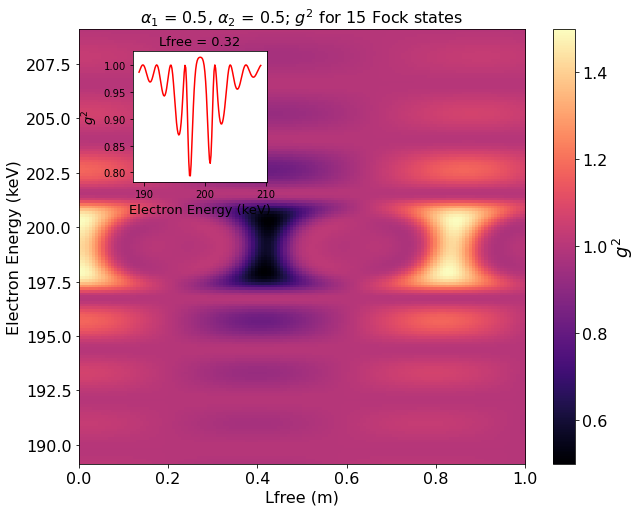

In [30]:
#########################################################################
# Number of Fock states to calculate with
n = loaded_metadata['n_states']-1
# The index of the time delay that we are using for the g2/Energy or g2/Energy/Lfree plot
t_ind = 0

if str(n) not in g2.keys() or str(t_ind) not in g2[str(n)].keys():
    g2tempArr = np.zeros((len(Es), len(Lfree)))

    for ct, (e,l,t) in enumerate(intm1):
        i = np.argwhere((Es==e))
        j = np.argwhere((Lfree==l))
        k = np.argwhere((t_delay[j][0][0]==t))

        if t_ind==k[0][0]:
            g2tempArr[i,j] = g2_FromFinalState(prob_mats[ct,:,:], n)
            
        else:
            print(t_ind, k)
            sys.exit()

    g2[str(n)] = dict({str(t_ind): g2tempArr})
    
toplot = g2[str(n)][str(t_ind)]
#########################################################################
fig, ax = plt.subplots(1,1, figsize=(10,8))
#################################
# IF style = 'lines'
style = 'heat'


# IF style = 'heat'
# style = 'heat'
inset = True
inset_index = 45 #
#################################
# ax.set_title(r"Coupling g(E) $\in \left({:.4f}, {:.4f}\right)$, " \
#              r"$\alpha$ = {}, " \
#              r"$ g^2$ for {} Fock states".format(np.min(g2[str(n)]), np.max(g2[str(n)]),
#                                                 loaded_metadata['alpha1'],
#                                                  n+1))
ax.set_title(r"$\alpha_1$ = {}, $\alpha_2$ = {}; " \
             r"$ g^2$ for {} Fock states".format(loaded_metadata['alpha1'], loaded_metadata['alpha2'],
                                                 n+1))

if style == 'heat':
    im = ax.imshow(toplot, origin='lower', extent=[Lfree[0], Lfree[-1], Es[0]*1e-3, Es[-1]*1e-3],
                   cmap='magma', aspect='auto', interpolation='None')
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax)
    # cbar.set_label('$g^2$', size=18)
    cbar.set_label('$g^2$', size=18)
    # Colorbar tick sizes
    cbar.ax.tick_params(labelsize=16)
    
    ax.set_xlabel('Lfree (m)')
    ax.set_ylabel('Electron Energy (keV)')
    
    if inset:
        vertical_strip = toplot[:,inset_index]
        
#         ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right',
#                              bbox_to_anchor=(-.1, -.1, 1, 1), bbox_transform=ax.transAxes)
        ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper left',
                             bbox_to_anchor=(.11, -.04, 1, 1), bbox_transform=ax.transAxes)
    
        # Plot the vertical strip data in the inset axis
        ax_inset.plot(Es*1e-3, vertical_strip, 'r-')
        ax_inset.set_title('Lfree = {:.2f}'.format(Lfree[inset_index]))
        ax_inset.set_ylabel('$g^2$')
        ax_inset.set_xlabel('Electron Energy (keV)')
        
        fontsizes2d(ax_inset, 13,10)
        
    
elif style =='lines':
    for i, l in enumerate(Lfree):
        ax.plot(Es[::]*1e-3, toplot[:,i][::], label = 'Lfree={}'.format(l))
        
#     ax.legend(True)
    
    ax.set_xlabel('Electron Energy (keV)')
    ax.set_ylabel('$g^2$')



fontsizes2d(ax, 16,16)

# g2 Save File
g2PNGfile = plot_file_umbrella + r'_g2_{}_FockStates.png'.format(n+1)
print(g2PNGfile)

fig.savefig(g2PNGfile, dpi=400, bbox_inches='tight')

## QMI

/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/numpy/lib/scimath.py:288: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)
<ipython-input-31-10b2e2a6379c>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  QMItempArr[i,j] = QMI(prob_mats[ct,:,:], n)


/storage/work/rjm6826/data/110124_154114_tcav_QMI_14_FockStates.png


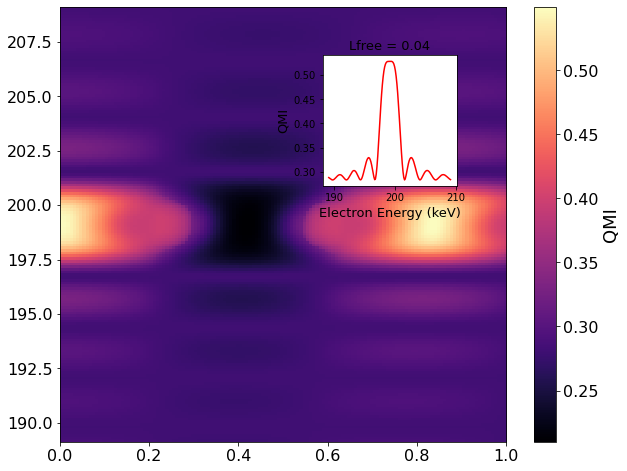

In [31]:
#########################################################################
n = loaded_metadata['n_states']-1

# if str(n) not in QMI_ar.keys():
#     QMItempArr = np.zeros((len(Es), len(Lfree)))
    
#     for i, E in enumerate(Es):
#         for j, l in enumerate(Lfree):
#             QMItempArr[i,j] = QMI(prob_mats[i,j,:,:], n)
            
#     QMI_ar[str(n)] = QMItempArr
    
t_ind = 0

if str(n) not in QMI_ar.keys() or str(t_ind) not in QMI_ar[str(n)].keys():
    QMItempArr = np.zeros((len(Es), len(Lfree)))

    for ct, (e,l,t) in enumerate(intm1):
        i = np.argwhere((Es==e))
        j = np.argwhere((Lfree==l))
        k = np.argwhere((t_delay[j][0][0]==t))

        if t_ind==k[0][0]:
            QMItempArr[i,j] = QMI(prob_mats[ct,:,:], n)
            
        else:
            print(t_ind, k)
            sys.exit()

    QMI_ar[str(n)] = dict({str(t_ind): QMItempArr})
    
toplot = QMI_ar[str(n)][str(t_ind)]
#########################################################################
fig2, ax2 = plt.subplots(1,1, figsize=(10,8))
#################################
# IF style = 'lines'
style = 'heat'


# IF style = 'heat'
# style = 'heat'
inset = True
inset_index = 5 #
#################################
# if loaded_metadata['Reference coupling'] != 0:
#     ax2.set_title("Constant coupling (g = {:.2f})" \
#                  r", $\alpha$ = {}, " \
#                  r"QMI for {} Fock states".format(loaded_metadata['Reference coupling'],
#                                                    loaded_metadata['alpha1'],
#                                                    n))
# else:
#     ax2.set_title("Variable coupling (g = g(E)), " \
#                  r"$\alpha$ = {}, " \
#                  r"QMI for {} Fock states".format(loaded_metadata['alpha1'],
#                                                    n))

if style == 'heat':
    im = ax2.imshow(toplot, origin='lower', extent=[Lfree[0], Lfree[-1], Es[0]*1e-3, Es[-1]*1e-3],
                   cmap='magma', aspect='auto', interpolation='None')
    
    # Colorbar
    cbar = fig2.colorbar(im, ax=ax2)
    # cbar.set_label('$g^2$', size=18)
    cbar.set_label('QMI', size=18)
    # Colorbar tick sizes
    cbar.ax.tick_params(labelsize=16)
    
    ax.set_xlabel('Lfree (m)')
    ax.set_ylabel('Electron Energy (keV)')
    
    if inset:
        vertical_strip = toplot[:,inset_index]
        
        ax_inset = inset_axes(ax2, width="30%", height="30%", loc='upper right',
                             bbox_to_anchor=(-.1, -.1, 1, 1), bbox_transform=ax.transAxes)
    
        # Plot the vertical strip data in the inset axis
        ax_inset.plot(Es*1e-3, vertical_strip, 'r-')
        ax_inset.set_title('Lfree = {:.2f}'.format(Lfree[inset_index]))
        ax_inset.set_ylabel('QMI')
        ax_inset.set_xlabel('Electron Energy (keV)')
        
        fontsizes2d(ax_inset, 13,10)
        
    
elif style =='lines':
    for i, l in enumerate(Lfree):
        ax2.plot(Es*1e-3, toplot, label = 'Lfree={}'.format(l))
        
#     ax.legend(True)
    
    ax2.set_xlabel('Electron Energy (keV)')
    ax2.set_ylabel('QMI')



fontsizes2d(ax2, 16,16)

# g2 Save File
g2PNGfile = plot_file_umbrella + r'_QMI_{}_FockStates.png'.format(n)
print(g2PNGfile)

fig2.savefig(g2PNGfile, dpi=400, bbox_inches='tight')

## Average number of photons in cavity 2, $\left< n_2 \right>$

<ipython-input-14-729c3bb6c8c2>:23: ComplexWarning: Casting complex values to real discards the imaginary part
  n2tempArr[i,j] = n2_brute(prob_mats[ct,:,:], n)


/storage/group/mzc267/default/rjm6826/data/062024_141419_tcav_n2_14_FockStates.png


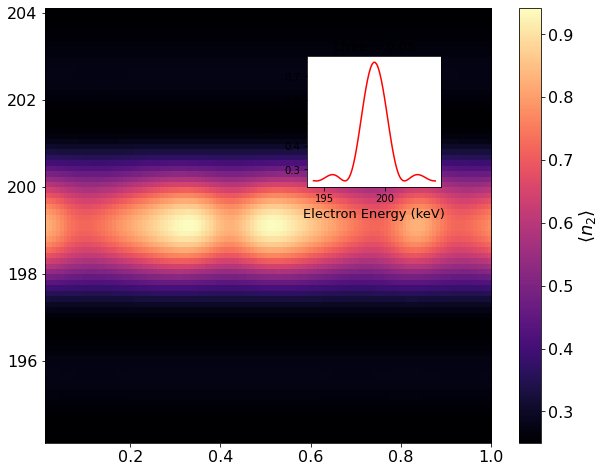

In [14]:
#########################################################################
n = loaded_metadata['n_states']-1

# if str(n) not in n2.keys():
#     n2tempArr = np.zeros((len(Es), len(Lfree)))
    
#     for i, E in enumerate(Es):
#         for j, l in enumerate(Lfree):
#             n2tempArr[i,j] = n2_brute(prob_mats[i,j,:,:], n)
            
#     n2[str(n)] = n2tempArr
t_ind = 0

if str(n) not in n2.keys() or str(t_ind) not in n2[str(n)].keys():
    n2tempArr = np.zeros((len(Es), len(Lfree)))

    for ct, (e,l,t) in enumerate(intm1):
        i = np.argwhere((Es==e))
        j = np.argwhere((Lfree==l))
        k = np.argwhere((t_delay[j][0][0]==t))

        if t_ind==k[0][0]:
            n2tempArr[i,j] = n2_brute(prob_mats[ct,:,:], n)
            
        else:
            print(t_ind, k)
            sys.exit()

    n2[str(n)] = dict({str(t_ind): n2tempArr})
    
toplot = n2[str(n)][str(t_ind)]
#########################################################################
fig3, ax3 = plt.subplots(1,1, figsize=(10,8))
#################################
# IF style = 'lines'
style = 'heat'


# IF style = 'heat'
# style = 'heat'
inset = True
inset_index = 5 #
#################################
# if loaded_metadata['Reference coupling'] != 0:
#     ax3.set_title("Constant coupling (g = {:.2f})" \
#                  r", $\alpha$ = {}, " \
#                  r"$\left< n_2 \right>$ for {} Fock states".format(loaded_metadata['Reference coupling'],
#                                                    loaded_metadata['alpha1'],
#                                                    n))
# else:
#     ax3.set_title("Variable coupling (g = g(E)), " \
#                  r"$\alpha$ = {}, " \
#                  r"$\left< n_2 \right>$ for {} Fock states".format(loaded_metadata['alpha1'],
#                                                    n))

if style == 'heat':
    im = ax3.imshow(toplot, origin='lower', extent=[Lfree[0], Lfree[-1], Es[0]*1e-3, Es[-1]*1e-3],
                   cmap='magma', aspect='auto')
    
    # Colorbar
    cbar = fig3.colorbar(im, ax=ax3)
    # cbar.set_label('$g^2$', size=18)
    cbar.set_label(r'$\left< n_2 \right>$', size=18)
    # Colorbar tick sizes
    cbar.ax.tick_params(labelsize=16)
    
    ax.set_xlabel('Lfree (m)')
    ax.set_ylabel('Electron Energy (keV)')
    
    if inset:
        vertical_strip = toplot[:,inset_index]
        
        ax_inset = inset_axes(ax3, width="30%", height="30%", loc='upper right',
                             bbox_to_anchor=(-.1, -.1, 1, 1), bbox_transform=ax.transAxes)
    
        # Plot the vertical strip data in the inset axis
        ax_inset.plot(Es*1e-3, vertical_strip, 'r-')
        ax_inset.set_title('Lfree = {:.2f}'.format(Lfree[inset_index]))
        ax_inset.set_ylabel(r'$\left< n_2 \right>$')
        ax_inset.set_xlabel('Electron Energy (keV)')
        
        fontsizes2d(ax_inset, 13,10)
        
    
elif style =='lines':
    for i, l in enumerate(Lfree):
        ax3.plot(Es*1e-3, toplot, label = 'Lfree={}'.format(l))
        
#     ax.legend(True)
    
    ax3.set_xlabel('Electron Energy (keV)')
    ax3.set_ylabel(r'$\left< n_2 \right>$')



fontsizes2d(ax3, 16,16)

# g2 Save File
g2PNGfile = plot_file_umbrella + r'_n2_{}_FockStates.png'.format(n)
print(g2PNGfile)

fig3.savefig(g2PNGfile, dpi=400, bbox_inches='tight')

## Combining multiple measurements--lines only

/storage/group/mzc267/default/rjm6826/data/062024_141419_tcav_MeasCombo_Lfree_0.3843697478991596_n_14.png


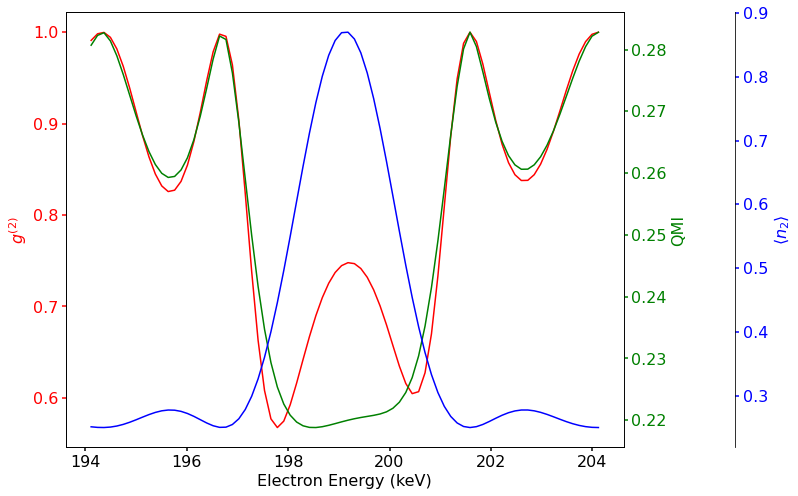

In [15]:
n = loaded_metadata['n_states']-1

fig_c, ax_c = plt.subplots(1,1, figsize=(10,8))

ax_c2 = ax_c.twinx()
ax_c3 = ax_c.twinx()
ax_c3.spines["right"].set_position(("axes", 1.2))

l_ind = 45
Lfreep = [Lfree[l_ind]]

for i, l in enumerate(Lfreep):
    p1, = ax_c.plot(Es*1e-3, g2[str(n)][str(t_ind)][:,l_ind], label = 'Lfree={}'.format(l), color='red')
    ax_c.set_xlabel('Electron Energy (keV)')
    ax_c.set_ylabel(r'$g^{(2)}$')

for i, l in enumerate(Lfreep):
    p2, = ax_c2.plot(Es*1e-3, QMI_ar[str(n)][str(t_ind)][:,l_ind], label = 'Lfree={}'.format(l), color='green')
    ax_c2.set_ylabel(r'QMI')

for i, l in enumerate(Lfreep):
    p3, = ax_c3.plot(Es*1e-3, n2[str(n)][str(t_ind)][:,l_ind], label = 'Lfree={}'.format(l), color='blue')
    ax_c3.set_ylabel(r'$\left< n_2 \right>$')

ax_c.yaxis.label.set_color(p1.get_color())
ax_c2.yaxis.label.set_color(p2.get_color())
ax_c3.yaxis.label.set_color(p3.get_color())

# ax_c.legend()
# ax_c2.legend()
# ax_c3.legend()

fontsizes2d(ax_c, 16,16)
fontsizes2d(ax_c2, 16,16)
fontsizes2d(ax_c3, 16,16)

tkw = dict(size=4, width=1.5)
ax_c.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax_c2.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax_c3.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax_c.tick_params(axis='x', **tkw)

# Measurment combination Save File
MeasComboPNGfile = plot_file_umbrella \
                    + r'_MeasCombo_Lfree_{}_n_{}.png'.format(Lfree[l_ind],n)
print(MeasComboPNGfile)

fig_c.savefig(MeasComboPNGfile, dpi=600, bbox_inches='tight')

# data_out = np.array([g2[str(n)][str(t_ind)][:,l_ind], 
#                     n2[str(n)][str(t_ind)][:,l_ind], 
#                     QMI_ar[str(n)][str(t_ind)][:,l_ind]])
# np.savetxt(plot_file_umbrella + "ThreeMeasureProblem.csv", data_out, delimiter=",")

## Resolving g2

In [11]:
prob_m.shape

NameError: name 'prob_m' is not defined

/storage/home/rjm6826/data/tcav_052124_125326_g2Resolution_ntimes_100.png


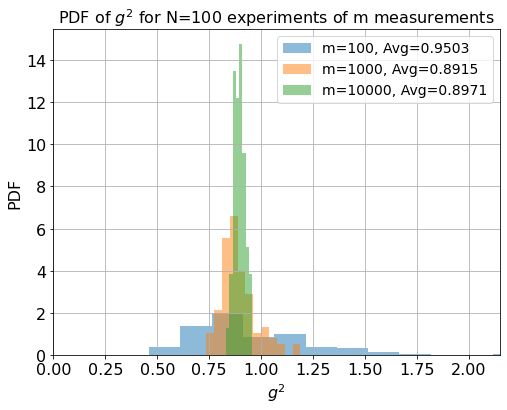

In [12]:
# m_measurements = [100, 1000, 10000, 100000]
m_measurements = [100, 1000, 10000]
n_times = int(1e2)

fig4, ax4 = plt.subplots(figsize=(8,6))
ax4.set_ylabel('PDF', fontsize=16)
ax4.set_xlabel('$g^2$', fontsize=16)

prob_m = prob_mats[30]

for j, m in enumerate(m_measurements):
#     if j>2: break
#     if j != 1: continue
    g2test2 = g2_sampler(np.abs(prob_m), m, n_times)

    # Define bins with bin_width = .01
#     bin_width = bin_widths[j]
#     bins = np.arange(np.min(g2test2), np.max(g2test2), bin_width)

    avg = np.mean(g2test2)

    hist0 = ax4.hist(g2test2, bins='fd', density=True,
                     alpha = .5,
                     label = 'm={}, Avg={:.4f}'.format(m, avg))
    

#     # Total probability for g2 in the photon-photon statistic we calculated
#     total_p = np.sum(pdf*bin_width)

#     print('Total prob {:.4f}'.format(total_p))

ax4.legend(fontsize=14)

ax4.grid(True)

ax4.set_title(r'PDF of $g^2$ for N={} experiments of m measurements'.format(n_times), fontsize=16)

fontsizes2d(ax4, 16,16)

ax4.set_xlim([0,2.15])

# g2 Save File
g2ResolutionPNGfile = plot_file_umbrella + r'_g2Resolution_ntimes_{}.png'.format(n_times)
print(g2ResolutionPNGfile)

# fig4.savefig(g2ResolutionPNGfile, dpi=400, bbox_inches='tight')

## Resolving QMI

/storage/home/rjm6826/PHYS_testing_gnds/PHYS_Testing/bkgndLibs/PINEM.py:482: RuntimeWarning: divide by zero encountered in log2
  qmis[i] -= np.sum(np.multiply(rho_new, np.log2(rho_new),


/storage/home/rjm6826/data/tcav_052124_125326_qmiResolution_ntimes_10000.png


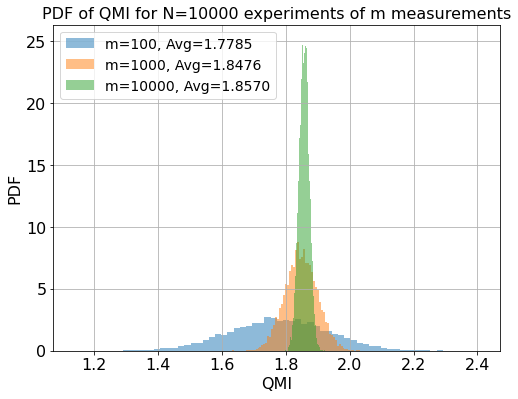

In [13]:
m_measurements = [100, 1000, 10000]
n_times = int(1e4)

fig5, ax5 = plt.subplots(figsize=(8,6))
ax5.set_ylabel('PDF', fontsize=16)
ax5.set_xlabel('QMI', fontsize=16)

prob_m = prob_mats[30]

for j, m in enumerate(m_measurements):
    qmitest = qmi_sampler(np.abs(prob_m), m, n_times)

    # Define bins with bin_width = .01
#     bin_width = bin_widths[j]
#     bins = np.arange(np.min(g2test2), np.max(g2test2), bin_width)

    avg = np.mean(qmitest)

    hist0 = ax5.hist(qmitest, bins='fd', density=True,
                     alpha = .5,
                     label = 'm={}, Avg={:.4f}'.format(m, avg))
    

#     # Total probability for g2 in the photon-photon statistic we calculated
#     total_p = np.sum(pdf*bin_width)

#     print('Total prob {:.4f}'.format(total_p))

ax5.legend(fontsize=14)

ax5.grid(True)

ax5.set_title(r'PDF of QMI for N={} experiments of m measurements'.format(n_times), fontsize=16)

fontsizes2d(ax5, 16,16)

# ax5.set_xlim([0,2.15])

# g2 Save File
qmiResolutionPNGfile = plot_file_umbrella + r'_qmiResolution_ntimes_{}.png'.format(n_times)
print(qmiResolutionPNGfile)

# fig5.savefig(qmiResolutionPNGfile, dpi=400, bbox_inches='tight')

## Resolving g2, n2, and QMI

In [16]:
# m_measurements = [100, 1000, 10000, 100000]
m_measurements = [int(1e3)]
n_times = int(5e5)

prob_m = prob_mats[30,0]

for j, m in enumerate(m_measurements):
    meas_outcomes = threeMeasSamp(np.abs(prob_m), m, n_times)

    avg_g2 = np.mean(meas_outcomes[0])
    avg_n2 = np.mean(meas_outcomes[1])
    avg_mpi = np.mean(meas_outcomes[2])

    hist_g2, bins_g2 = np.histogram(meas_outcomes[0], bins='fd', density=True)
    hist_n2, bins_n2 = np.histogram(meas_outcomes[1], bins='fd', density=True)
    hist_qmi, bins_qmi = np.histogram(meas_outcomes[2], bins='fd', density=True)


<ipython-input-15-abf93d2c57fd>:56: RuntimeWarning: divide by zero encountered in log2
  qmi = np.sum(np.multiply(rho_new, np.log2(rho_new), where=(rho_new!=0)))


In [17]:
bins_qmi

array([-2.08762418, -2.08589777, -2.08417136, -2.08244495, -2.08071854,
       -2.07899213, -2.07726573, -2.07553932, -2.07381291, -2.0720865 ,
       -2.07036009, -2.06863368, -2.06690727, -2.06518087, -2.06345446,
       -2.06172805, -2.06000164, -2.05827523, -2.05654882, -2.05482242,
       -2.05309601, -2.0513696 , -2.04964319, -2.04791678, -2.04619037,
       -2.04446396, -2.04273756, -2.04101115, -2.03928474, -2.03755833,
       -2.03583192, -2.03410551, -2.03237911, -2.0306527 , -2.02892629,
       -2.02719988, -2.02547347, -2.02374706, -2.02202065, -2.02029425,
       -2.01856784, -2.01684143, -2.01511502, -2.01338861, -2.0116622 ,
       -2.00993579, -2.00820939, -2.00648298, -2.00475657, -2.00303016,
       -2.00130375, -1.99957734, -1.99785094, -1.99612453, -1.99439812,
       -1.99267171, -1.9909453 , -1.98921889, -1.98749248, -1.98576608,
       -1.98403967, -1.98231326, -1.98058685, -1.97886044, -1.97713403,
       -1.97540762, -1.97368122, -1.97195481, -1.9702284 , -1.96

MovieWriter ffmpeg unavailable; using Pillow instead.


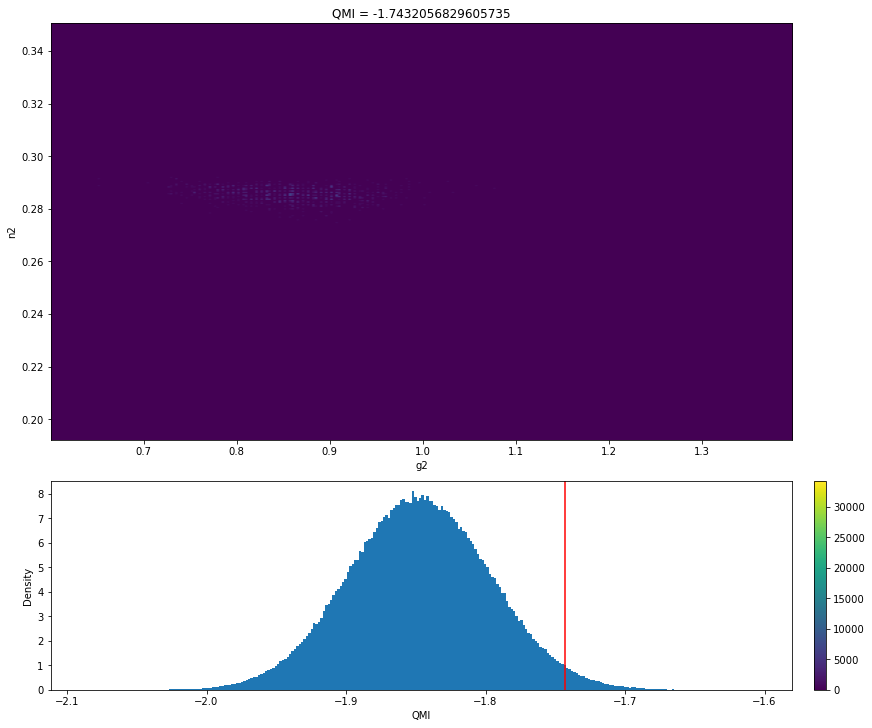

In [19]:
# Create meshgrid for g2 and n2
g2_centers = 0.5 * (bins_g2[:-1] + bins_g2[1:])
n2_centers = 0.5 * (bins_n2[:-1] + bins_n2[1:])
qmi_centers = 0.5 * (bins_qmi[:-1] + bins_qmi[1:])
g2_grid, n2_grid = np.meshgrid(g2_centers, n2_centers)

# Function to calculate the probability density
def calc_prob_density(g2, n2, qmi, bins_g2, bins_n2, bins_qmi):
    hist_3d, edges = np.histogramdd(
        np.vstack([g2, n2, qmi]).T,
        bins=[bins_g2, bins_n2, bins_qmi],
        density=True
    )
    return hist_3d

# Calculate the 3D histogram for the given data
hist_3d = calc_prob_density(meas_outcomes[0], meas_outcomes[1], meas_outcomes[2], 
                            bins_g2, bins_n2, bins_qmi)

# Set up the figure and axis
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[3,1])
fig = plt.figure(constrained_layout=True, figsize=(12, 10))

# Define the grid
gs = gridspec.GridSpec(3, 1, figure=fig)

# Create the subplots
ax1 = fig.add_subplot(gs[0:2, :])
ax2 = fig.add_subplot(gs[2, :])


cax = ax1.imshow(hist_3d[:, :, 0], interpolation=None, 
                origin='lower', aspect='auto',
                extent=[g2_centers[0], g2_centers[-1], n2_centers[0], n2_centers[-1]],
                vmax=np.max(hist_3d))
fig.colorbar(cax)
ax1.set_xlabel('g2')
ax1.set_ylabel('n2')

# Function to update the heatmap for each frame
def update(frame):
    ax1.clear()
    ax2.clear()
    
    cax = ax1.imshow(hist_3d[:, :, frame], interpolation=None, 
                    origin='lower', aspect='auto',
                    extent=[g2_centers[0], g2_centers[-1], n2_centers[0], n2_centers[-1]],
                    vmax=np.max(hist_3d))
    ax1.set_title(f'QMI = {qmi_centers[frame]}')
    ax1.set_xlabel('g2')
    ax1.set_ylabel('n2')
    
    # Update the histogram
    ax2.bar(bins_qmi[:-1], hist_qmi, width=np.diff(bins_qmi), align='edge')
    ax2.axvline(qmi_centers[frame], color='r')  # Moving indicator
    ax2.set_xlabel('QMI')
    ax2.set_ylabel('Density')
    
    return cax,

# Create the animation
ani = animation.FuncAnimation(fig, update, 
                              frames=200, 
                              blit=False, repeat=True)

# Save the animation as an mp4 file
anifile = plot_file_umbrella \
                    + r'3axis_ntimes_{}_m_{}.gif'.format(n_times, m_measurements[0])
ani.save(anifile, writer='ffmpeg', fps=4, dpi=500)


# Scrap

Total prob 0.9999
Total prob 0.9999
Total prob 0.9999
Total prob 0.9999


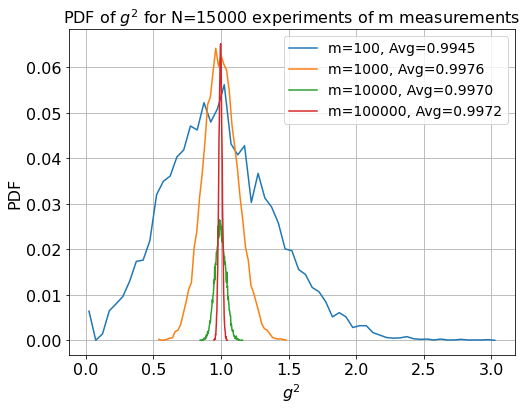

In [11]:
m_measurements = [100, 1000, 10000, 100000]
n_times = 15000 # 4000

fig3, ax3 = plt.subplots(figsize=(8,6))
ax3.set_ylabel('PDF', fontsize=16)
ax3.set_xlabel('$g^2$', fontsize=16)

prob_m = prob_mats[10]

bin_widths = [1/20, 2/100, 1/400, 1/500]


for j, m in enumerate(m_measurements):
    g2test2 = g2_sampler(np.abs(prob_m), m, n_times)

    # Define bins with bin_width = .01
    bin_width = bin_widths[j]
    bins = np.arange(np.min(g2test2), np.max(g2test2), bin_width)

    # Bin the samples for plotting
    bin_vals, bin_edges, bin_number = stats.binned_statistic(g2test2, values=np.ones_like(g2test2), statistic='count', 
                                                             bins=bins)
    xs = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bins)-1)]

    # Calculate the bin width
    bin_width = bin_edges[1] - bin_edges[0]

    # Calculate the PDF by normalizing bin_vals
    pdf = bin_vals / n_times / bin_width

    # Total probability for g2 in the photon-photon statistic we calculated
    total_p = np.sum(pdf*bin_width)

    # Calculate the average g2 for the n-sample distribution
    bin_mean = np.sum(g2test2) / n_times

    # Plot
    ax3.plot(xs, pdf*bin_width, label='m={}, Avg={:.4f}'.format(m, bin_mean))

    print('Total prob {:.4f}'.format(total_p))

ax3.legend(fontsize=14)

ax3.grid(True)

ax3.set_title(r'PDF of $g^2$ for N={} experiments of m measurements'.format(n_times), fontsize=16)

fontsizes2d(ax3, 16,16)


# Show a single energy vs g2

In [26]:
np.sinh(.5)**2

0.2715403174076219

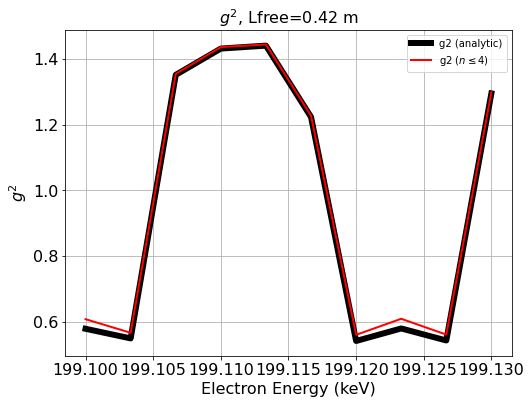

In [27]:
ind = -1

g2_2plot = g2bn[:,ind,0]
g26_2plot = g2b4[:,ind,0]

# g2_2plot = g2bn[:,-8,1]
# g26_2plot = g2b4[:,-8,1]

fig4, ax4 = plt.subplots(figsize=(8,6))

ax4.set_ylabel('$g^2$', fontsize=16)

ax4.set_xlabel('Electron Energy (keV)', fontsize=16)

ax4.plot(Es*1e-3, g2_2plot, label='g2 (analytic)', lw=6, color='black')
ax4.plot(Es*1e-3, g26_2plot, label=r'g2 ($n \leq 4$)', color='red', lw=2)

ax4.set_title('$g^2$, Lfree={:.2f} m'.format(Lfree[ind]))

fontsizes2d(ax4, 16,16)
ax4.legend()
ax4.grid()

In [ ]:
# Plot the difference between the two g2 values
fig5, ax5 = plt.subplots(figsize=(4,3))

ax5.set_ylabel('$\Delta g^2$', fontsize=16)

ax5.set_xlabel('Electron Energy (keV)', fontsize=16)

ax5.plot(Es*1e-3, -(g2_2plot - g26_2plot), label='g2 (analytic)', lw=1, color='black')

ax5.set_yscale('log')

## Average n2

In [ ]:
# Calculates the average number of photons in cavity 2
def avgn2(rho, n):
    '''
    avgn2: Calculates the average number of photons in cavity 2.
    rho: The density matrix of the 2 photon system.
    n: The maximum number of photons to consider.
    '''
    # Calculate the average number of photons in cavity 2
    avg_n2 = np.sum([i*np.abs(rho[n,i])**2 for i in range(rho.shape[1])])

    return avg_n2

## How far apart are the final photonic states?

In [ ]:
for i, E in enumerate(Es):
    # Compare the density matrix to a baseline
    difference_matrix = prob_mats[i] - prob_mats[0]
    frobenius_norm = np.linalg.norm(difference_matrix, 'fro')

    print(f"Frobenius norm of the difference: {frobenius_norm}")